In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as celery
celery.__version__

'0.4.0'

In [2]:
np.random.seed(42)
%matplotlib inline

#### set up the power spectrum:

In [3]:
a_max = 0.55 # amplitude of central mode in m/s
nu_max = 3.1e-3 # peak frequency in Hz
c_env = 0.331e-3 # envelope width in Hz
delta_nu = 0.00013 # Hz
freq_grid = np.arange(nu_max - 0.001, nu_max + 0.001, delta_nu) # magic numbers for l=0 modes
l_grid = np.append(np.zeros_like(freq_grid), np.ones_like(freq_grid))
freq_grid = np.append(freq_grid, freq_grid)
freq_grid += l_grid * 0.5 * delta_nu # add l=1 modes
omega_grid = 2.*np.pi*freq_grid # angular frequencies
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
amp_grid -= 0.4 * amp_grid * l_grid # l=1 modes

In [4]:
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)

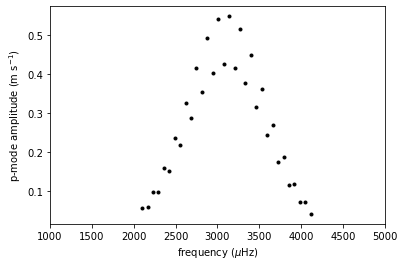

In [5]:
# check it:
plt.plot(freq_grid * 1.e6, np.sqrt(amp_grid), 'k.')
plt.ylabel('p-mode amplitude (m s$^{-1}$)')
plt.xlabel('frequency ($\mu$Hz)')
plt.xlim([1000,5000]);

In [6]:
# celery-friendly:
log_S0_grid = [np.log(d**2 / (dt * o)) for o,d in zip(omega_grid,driving_amp_grid)]  # velocity variance * kicks / radian

#### generate dense grid of RVs with GP model:

In [7]:
# time grid:
dt = 10. # seconds
timespan = 365. # days
ts = dt * np.arange(timespan * 24. * 3600. / dt)

In [8]:
# GP kernel:
kernel = None
for o,lS in zip(omega_grid,log_S0_grid):
    if kernel is None:
        kernel = celery.terms.SHOTerm(lS, np.log(o/gamma), np.log(o))
    else:
        kernel += celery.terms.SHOTerm(lS, np.log(o/gamma), np.log(o)) 

In [9]:
# run GP:
gp = celery.GP(kernel)
gp.compute(ts)
rvs = gp.sample()

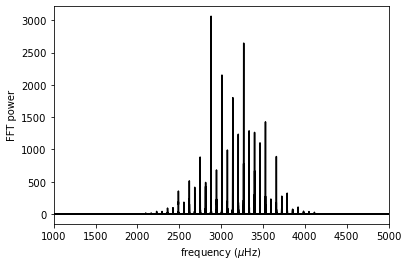

In [10]:
# check the power spectrum:
powers = np.fft.fft(rvs)
real_powers = (powers * powers.conj()).real
fs = np.fft.fftfreq(rvs.shape[-1]) / dt
fft = np.copy(real_powers/1e6)
plt.plot(fs*1e6, fft, 'k-')
plt.xlim([1000,5000])
plt.ylabel('FFT power')
plt.xlabel('frequency ($\mu$Hz)');

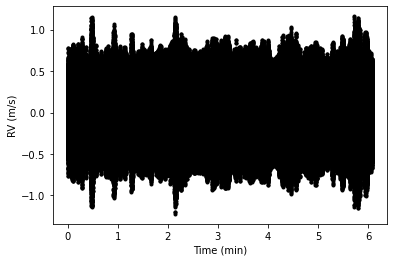

In [19]:
# check the RVs:
plt.plot(ts/60., rvs, 'k.')
plt.xlim([0, 100])
plt.xlabel('Time (min)')
plt.ylabel('RV (m/s)');

In [12]:
# save it:
with open('asteroseismic_noise_dense.csv', 'w') as f:
    f.write('ts,rvs\n')
    for i in range(len(ts)):
        f.write('{0:.8f},{1:.8f}\n'.format(ts[i],rvs[i]))

#### code for binning to longer exposures:

In [20]:
from scipy.interpolate import interp1d

def simulate_exposure(ts, rvs, start_time, exp_time):
    '''
    returns simulated RV for one exposure.
    
    inputs
    ------
    ts : densely sampled times
    rvs : densely sampled RVs
    start_time : timestamp (in units of ts) for start of exposure
    exp_time : duration of exposure
    '''
    pad = exp_time * 0.5 # arbitrary
    smaller_inds = (ts > (start_time - pad)) & (ts < (start_time + exp_time + pad))    
    interp = interp1d(ts[smaller_inds], rvs[smaller_inds], kind='cubic')
    tiny = exp_time / 1000
    fine_ts = np.arange(start_time, start_time+exp_time, tiny) # fine grid
    fine_rvs = interp(fine_ts)
    return np.sum(fine_rvs)/len(fine_rvs) # ASSUMES EVEN WEIGHTING - technically incorrect for last point

In [21]:
def simulate_many_exposures(ts, rvs, obs_times, exp_times):
    '''
    returns simulated RVs for multiple exposures.
    the exposures can be different lengths.
    
    inputs
    ------
    ts : densely sampled times
    rvs : densely sampled RVs
    obs_times : timestamps (in units of ts) for exposures
    exp_times : durations of exposures (should be same length as start_times)
    '''  
    many_rvs = np.zeros_like(obs_times)
    for i,(ot,et) in enumerate(zip(obs_times, exp_times)):
        start_time = ot - et/2. # assumes obs_time is the exposure midpoint
        many_rvs[i] = simulate_exposure(ts, rvs, start_time, et)
    return many_rvs

In [22]:
# get densely sampled times & rvs for input:
d = np.genfromtxt('asteroseismic_noise_dense.csv', names=True, dtype=None, delimiter=',')
dense_ts = np.copy(d['ts']) / 3600. / 24. # convert seconds to days
dense_rvs = np.copy(d['rvs'])

In [23]:
obs_times = np.arange(181) + 0.5  # nightly observation times (units of days)
obs_times += np.random.normal(0, 0.5/24., 181) # inject some randomness
exp_times = np.zeros_like(obs_times) + 5. / 60. / 24. # 5-minute exposures every time
obs_rvs = simulate_many_exposures(dense_ts, dense_rvs, obs_times, exp_times)

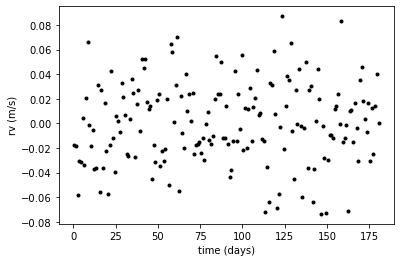

In [24]:
plt.plot(obs_times, obs_rvs, 'k.')
plt.xlabel('time (days)')
plt.ylabel('rv (m/s)');